In [ ]:
# !module load anaconda3
# !activate e1
# !pip install --user numpy
# !pip install --user "monai-weekly[nibabel, tqdm]"
# !pip install --user matplotlib
# %matplotlib inline
# !pip install --user nibabel
# !pip install --user SimpleITK
# !pip install --user helpers
# !pip install --user antspyx

# !pip install --user antspynet

In [ ]:
import os
import glob
import torch
import time
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader,random_split
from monai.transforms import (
    Compose, LoadImage, EnsureChannelFirst, EnsureType, Orientation, Spacing,
    RandSpatialCrop, RandFlip, NormalizeIntensity, RandScaleIntensity, RandShiftIntensity
)
from monai.networks.nets import SegResNet
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.data import DataLoader, decollate_batch
from monai.inferers import sliding_window_inference
from monai.utils import set_determinism
from monai.config import print_config
from monai.transforms import (
    Activations,
    AsDiscrete,
    EnsureTyped,
    MapTransform,
    AsDiscreted,
    Orientationd,
    Spacingd,
    RandSpatialCropd,
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    EnsureTyped,
    ConvertToMultiChannelBasedOnBratsClassesd,
    Orientationd,
    Spacingd,
    RandSpatialCropd,
    RandFlipd,
    NormalizeIntensityd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    Activations,
    AsDiscrete
)
from torch.utils.data import Subset
import nibabel

In [ ]:
from monai.data import Dataset
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, EnsureTyped

class CustomBraTSDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.data = []
        image_dir = os.path.join(data_dir, "imagesTr")
        label_dir = os.path.join(data_dir, "labelsTr")

        patient_ids = set()
        for filename in os.listdir(image_dir):
            if filename.endswith(".nii.gz"):
                patient_id = filename.split('_')[0]
                patient_ids.add(patient_id)

        for patient_id in patient_ids:
            self.data.append({
                "image": [
                    os.path.join(image_dir, f"{patient_id}_0001.nii.gz"),
                    os.path.join(image_dir, f"{patient_id}_0001.nii.gz"),
                    os.path.join(image_dir, f"{patient_id}_0002.nii.gz"),
                    os.path.join(image_dir, f"{patient_id}_0003.nii.gz")
                ],
                "label": os.path.join(label_dir, f"{patient_id}.nii.gz")
            })
        super().__init__(self.data, transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data = self.data[index]
        if self.transform:
            data = self.transform(data)
        return data

In [ ]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the peritumoral edema
    label 2 is the GD-enhancing tumor
    label 3 is the necrotic and non-enhancing tumor core
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            #Label 1 NEC
            result.append(d[key] == 1)
            #Label 2 SNFH
            result.append(d[key] == 2)
            #Label 3 ET
            result.append(d[key] == 3)
            #Label 4 RC
            result.append(d[key] == 4)

            d[key] = torch.stack(result, axis=0).float()
        return d

In [ ]:

train_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        RandSpatialCropd(keys=["image", "label"], roi_size=[ 182, 218, 182 ], random_size=False),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
    ]
)

val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)


In [ ]:
root_dir = ""
full_dataset = CustomBraTSDataset(data_dir=root_dir, transform=None)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)

In [ ]:
print(full_dataset)

In [ ]:
img,label=train_dataset[0]
print(train_dataset[0]['image'].shape)
print(train_dataset[0]['label'].shape)

torch.Size([4, 182, 218, 182])
torch.Size([4, 182, 218, 182])


image shape: torch.Size([4, 182, 218, 182])


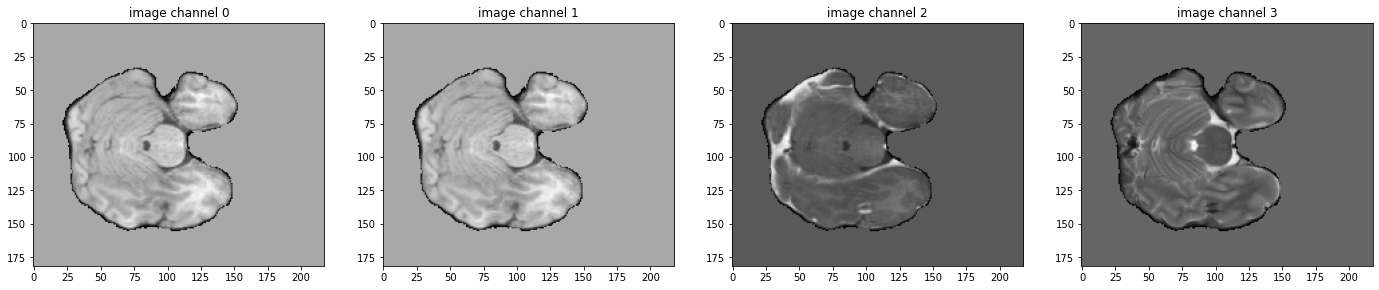

label shape: torch.Size([4, 182, 218, 182])


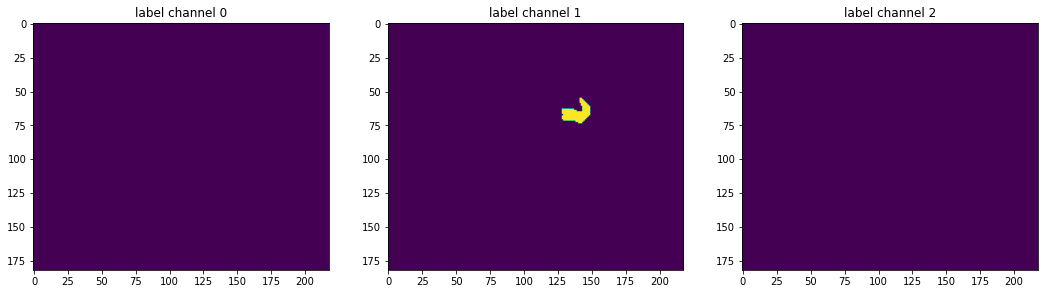

In [ ]:
val_data_example = val_dataset[2]
print(f"image shape: {val_data_example['image'].shape}")
plt.figure("image", (24, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(val_data_example["image"][i, :, :, 60].detach().cpu(), cmap="gray")
plt.show()
print(f"label shape: {val_data_example['label'].shape}")
plt.figure("label", (18, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(val_data_example["label"][i, :, :, 60].detach().cpu())
plt.show()

In [1]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, groups=8):
        super(ResidualBlock, self).__init__()
        self.norm1 = nn.GroupNorm(groups, out_channels)
        self.norm2 = nn.GroupNorm(groups, out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.norm1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.norm2(out)
        out += identity
        out = self.relu(out)
        return out

class SegResNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SegResNet, self).__init__()
        self.convInit = nn.Conv3d(in_channels, 16, kernel_size=3, padding=1, bias=False)
        self.relu = nn.ReLU(inplace=True)

        self.down1 = nn.Sequential(
            nn.Identity(),
            ResidualBlock(16, 16)
        )

        self.down2 = nn.Sequential(
            nn.Conv3d(16, 32, kernel_size=3, stride=2, padding=1, bias=False),
            ResidualBlock(32, 32),
            ResidualBlock(32, 32)
        )

        self.down3 = nn.Sequential(
            nn.Conv3d(32, 64, kernel_size=3, stride=2, padding=1, bias=False),
            ResidualBlock(64, 64),
            ResidualBlock(64, 64)
        )

        self.down4 = nn.Sequential(
            nn.Conv3d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            ResidualBlock(128, 128),
            ResidualBlock(128, 128),
            ResidualBlock(128, 128),
            ResidualBlock(128, 128)
        )

        self.up1 = nn.Sequential(
            nn.Conv3d(128, 64, kernel_size=1, bias=False),
            nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True),
            ResidualBlock(64, 64)
        )

        self.up2 = nn.Sequential(
            nn.Conv3d(64, 32, kernel_size=1, bias=False),
            nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True),
            ResidualBlock(32, 32)
        )

        self.up3 = nn.Sequential(
            nn.Conv3d(32, 16, kernel_size=1, bias=False),
            nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True),
            ResidualBlock(16, 16)
        )

        self.conv_final = nn.Sequential(
            nn.GroupNorm(8, 16),
            nn.ReLU(inplace=True),
            nn.Conv3d(16, out_channels, kernel_size=1)
        )

        self.dropout = nn.Dropout3d(p=0.2)

    def forward(self, x):
        x = self.convInit(x)
        x = self.relu(x)

        x = self.down1(x)
        x = self.down2(x)
        x = self.down3(x)
        x = self.down4(x)

        x = self.up1(x)
        x = self.up2(x)
        x = self.up3(x)

        x = self.conv_final(x)
        x = self.dropout(x)

        x = x[:, :, :182, :218, :182]

        return x

model = SegResNet(in_channels=4, out_channels=4)

In [ ]:
max_epochs = 300
val_interval = 1
VAL_AMP = True

# standard PyTorch program style: create SegResNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model.to(device)
loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(182, 218, 182 ),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)

scaler = torch.cuda.amp.GradScaler()
torch.backends.cudnn.benchmark = True

In [ ]:
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], [], []]
epoch_loss_values = []
metric_values = []
metric_values_et = []
metric_values_rc = []
metric_values_snfh = []
metric_values_nec = []

total_start = time.time()
for epoch in range(max_epochs):
    print(device)
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs=batch_data["image"].to(device)
        batch_data["image"]=batch_data["image"].detach().cpu()
        labels=batch_data["label"].to(device)
        batch_data["label"]=batch_data["label"].detach().cpu()
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_dataset) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
    print("@!")
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_data["image"]=val_data["image"].detach().cpu()
                val_data["label"]=val_data["label"].detach().cpu()
                val_outputs = inference(val_inputs)
                val_outputs = [post_trans(i) for i in val_outputs]
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()

            metric_nec = metric_batch[0].item()
            metric_values_nec.append(metric_nec)

            metric_snfh = metric_batch[1].item()
            metric_values_snfh.append(metric_snfh)

            metric_et = metric_batch[2].item()
            metric_values_et.append(metric_et)

            metric_rc = metric_batch[3].item()
            metric_values_rc.append(metric_rc)

            dice_metric.reset()
            dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join(root_dir, "best_metric_model.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\n nec: {metric_nec:.4f} snfh: {metric_snfh:.4f} et: {metric_et:.4f} rc: {metric_rc:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f"\n at epoch: {best_metric_epoch}"
            )
            with open('metrics_log.txt', 'a') as f:
                current_time = time.localtime()
                formatted_time = time.strftime("%Y-%m-%d %H:%M:%S", current_time)
                f.write(f" current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\n nec: {metric_nec:.4f} snfh: {metric_snfh:.4f} et: {metric_et:.4f} rc: {metric_rc:.4f}"
                f"\n best mean dice: {best_metric:.4f}"
                f"\n at epoch: {best_metric_epoch}\n"
                f"\nepoch end time: {formatted_time}\n")
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start

cuda:0
----------
epoch 1/300
1/1080, train_loss: 0.9960, step time: 3.1477
2/1080, train_loss: 0.9804, step time: 0.3640
3/1080, train_loss: 0.9891, step time: 0.4011
4/1080, train_loss: 0.9847, step time: 0.3995
5/1080, train_loss: 0.9810, step time: 0.3802
6/1080, train_loss: 0.9933, step time: 0.3967
7/1080, train_loss: 0.9903, step time: 0.3714
8/1080, train_loss: 0.9850, step time: 0.3845
9/1080, train_loss: 0.9976, step time: 0.3915
10/1080, train_loss: 0.9990, step time: 0.3867
11/1080, train_loss: 0.9884, step time: 0.4032
12/1080, train_loss: 0.9729, step time: 0.3849
13/1080, train_loss: 0.9852, step time: 0.4746
14/1080, train_loss: 0.9936, step time: 0.4000
15/1080, train_loss: 0.9689, step time: 0.3997
16/1080, train_loss: 0.9746, step time: 0.4407
17/1080, train_loss: 0.9880, step time: 0.3854


In [ ]:
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}, total time: {total_time}.")

In [ ]:
print(val_inputs.shape)

In [ ]:
print(inference(val_inputs).shape)

In [ ]:
print(val_outputs.shape)